### Se importan las librerías:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !pip install torchgeo
# !pip install GPUtil
# !pip install segmentation_models_pytorch

In [40]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm  as cm
from matplotlib.patches import Rectangle

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

from torchgeo.datasets import LoveDA

from GPUtil import showUtilization as gpu_usage

import time
import os

import segmentation_models_pytorch as smp

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch utiliza {}".format("GPU" if torch.cuda.is_available() else "CPU"))

PyTorch utiliza GPU


### Constantes:

In [6]:
ROOT_PATH = './drive/MyDrive/segmentation-loveDA/'
N_CLASSES = 8
NUM_EPOCHS = 20
BATCH_SIZE = 4
MAX_LR = 1e-3
WEIGHT_DECAY = 1e-4
SMOOTH = 1e-10
NUM_WORKERS = os.cpu_count() 
PIN_MEMORY = torch.cuda.is_available()

### Funciones Útiles:

In [4]:
def free_gpu_cache(verbose=False):
    if verbose:
        print("Initial GPU Usage")
        gpu_usage()                             

    torch.cuda.empty_cache()

    if verbose:
        print("GPU Usage after emptying the cache")
        gpu_usage()
free_gpu_cache(True)

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [5]:
class CustomDataset(LoveDA):

    def __getitem__(self, index: int):
        files = self.files[index]
        # Se lee la imagen según su indice
        image = cv2.imread(files["image"])
        # Convierte los colores de la imagen de BGR a RGB  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.split != "test":
            mask = cv2.imread(files["mask"], cv2.IMREAD_GRAYSCALE)
            sample = {"image": image, "mask": mask}
        else:
            sample = {"image": image}

        if self.transforms is not None:
            sample = self.transforms(**sample)

        sample['image'] = Image.fromarray(sample['image'])
        
        t = T.Compose([T.ToTensor()])
        sample['image'] = t(sample['image'])

        if self.split != "test":
            sample['mask'] = torch.from_numpy(sample['mask']).long()

        return sample

In [6]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [7]:
# mean intersection over union
def mIoU(pred_mask, mask, smooth=SMOOTH, n_classes=N_CLASSES):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [8]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [9]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):
    free_gpu_cache()
    train_losses = []
    val_losses = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []
    min_loss = np.inf
    not_improve = 0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(train_loader):
            #training phase
            image_tiles = data['image']    
            mask_tiles = data['mask']      
            image = image_tiles.to(device)
            mask = mask_tiles.to(device)
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        #validation loop
        with torch.no_grad():
            model.eval()
            val_loss = 0
            val_accuracy = 0
            val_iou_score = 0
            for i, data in enumerate(val_loader):
                #reshape to 9 patches from single image, delete batch size
                image_tiles = data['image']            
                mask_tiles = data['mask']    
                image = image_tiles.to(device)
                mask = mask_tiles.to(device)
                output = model(image)
                #evaluation metrics
                val_iou_score +=  mIoU(output, mask)
                val_accuracy += pixel_accuracy(output, mask)
                #loss
                loss = criterion(output, mask)                                  
                val_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            val_losses.append(val_loss/len(val_loader))                    

            if (val_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (val_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(val_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(val_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(val_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': val_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [10]:
def predict_image_mask_miou(model, image, mask):
    model.eval()
    model.to(device)
    image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [11]:
def predict_image_mask_pixel(model, image, mask):
    model.eval()
    model.to(device)
    image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [2]:
def predict_image_mask(model, image):
    model.eval()
    model.to(device)
    image=image.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        
    output = model(image)
    masked = torch.argmax(output, dim=1)
    masked = masked.cpu().squeeze(0)
    return masked

In [13]:
def miou_score(model, test_set):
    score_iou = []
    for i in range(len(test_set)):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [14]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in range(len(test_set)):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [47]:
def plot_colortable(colors, title, sort_colors=True, emptycols=0):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
        names = [name for hsv, name in by_hsv]
    else:
        names = list(colors)

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left", pad=10)

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

### Preprocesamiento:

Crear los datasets:

In [16]:
transform_train = A.Compose([A.GridDistortion(p=0.2), 
                             A.RandomBrightnessContrast((0,0.5),(0,0.5)), 
                             A.GaussNoise()])
transform_val = A.Compose([A.GridDistortion(p=0.2)])


#datasets
train_set = CustomDataset(root=ROOT_PATH, split="train", transforms=transform_train)
val_set = CustomDataset(root=ROOT_PATH, split="val", transforms=transform_val)
test_set = CustomDataset(root=ROOT_PATH, split="test")

#dataloader
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, 
                        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)               

train
val
test


In [17]:
total_len = len(train_set) + len(val_set) + len(test_set)
print('Train Size:', len(train_set), '({}%)'.format(round((len(train_set)/total_len)*100, 2)))
print('Val Size:', len(val_set), '({}%)'.format(round((len(val_set)/total_len)*100, 2)))
print('Test Size:', len(test_set), '({}%)'.format(round((len(test_set)/total_len)*100, 2)))

Train Size: 2522 (45.47%)
Val Size: 1669 (30.09%)
Test Size: 1355 (24.43%)


Tamaño de imagen: (1024, 1024, 3)
Tamaño de máscara: (1024, 1024)


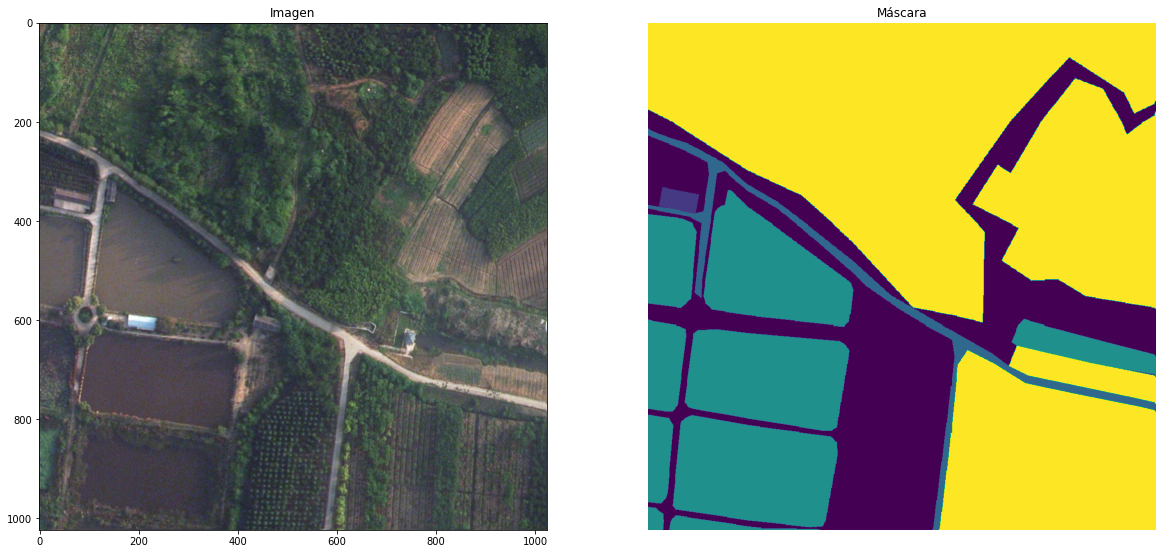

In [18]:
data = train_set[5]

t = T.Compose([T.ToPILImage()])
data['image'] = t(data['image'])

print('Tamaño de imagen:', np.asarray(data['image']).shape)
print('Tamaño de máscara:', np.asarray(data['mask']).shape)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(data['image'])
ax1.set_title('Imagen')

ax2.imshow(data['mask'])
ax2.set_title('Máscara')
ax2.set_axis_off()

### Modelo:

In [19]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=N_CLASSES, activation=None, 
    encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
# model

### Entrenamiento:

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=MAX_LR, weight_decay=WEIGHT_DECAY)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, MAX_LR, epochs=NUM_EPOCHS,
                                            steps_per_epoch=len(train_loader))

history = fit(NUM_EPOCHS, model, train_loader, val_loader, criterion, optimizer, sched)

Epoch:1/10.. Train Loss: 1.471.. Val Loss: 1.121.. Train mIoU:0.278.. Val mIoU: 0.356.. Train Acc:0.486.. Val Acc:0.578.. Time: 24.02m
Epoch:2/10.. Train Loss: 1.096.. Val Loss: 1.144.. Train mIoU:0.395.. Val mIoU: 0.342.. Train Acc:0.614.. Val Acc:0.560.. Time: 10.69m
Epoch:3/10.. Train Loss: 1.028.. Val Loss: 1.127.. Train mIoU:0.416.. Val mIoU: 0.354.. Train Acc:0.631.. Val Acc:0.611.. Time: 10.79m
Epoch:4/10.. Train Loss: 0.926.. Val Loss: 1.038.. Train mIoU:0.445.. Val mIoU: 0.394.. Train Acc:0.664.. Val Acc:0.615.. Time: 10.81m
Epoch:5/10.. Train Loss: 0.859.. Val Loss: 1.114.. Train mIoU:0.470.. Val mIoU: 0.392.. Train Acc:0.685.. Val Acc:0.612.. Time: 10.82m
Epoch:6/10.. Train Loss: 0.825.. Val Loss: 0.952.. Train mIoU:0.483.. Val mIoU: 0.413.. Train Acc:0.694.. Val Acc:0.675.. Time: 10.80m
Epoch:7/10.. Train Loss: 0.736.. Val Loss: 0.987.. Train mIoU:0.520.. Val mIoU: 0.418.. Train Acc:0.723.. Val Acc:0.667.. Time: 10.80m
Epoch:8/10.. Train Loss: 0.675.. Val Loss: 0.919.. Trai

In [21]:
torch.save(model, './drive/MyDrive/models/segmentation-unet-2.pt')

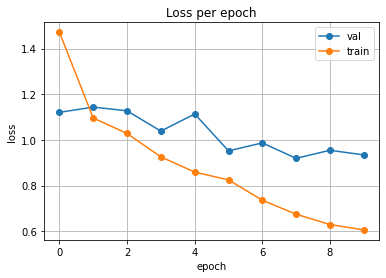

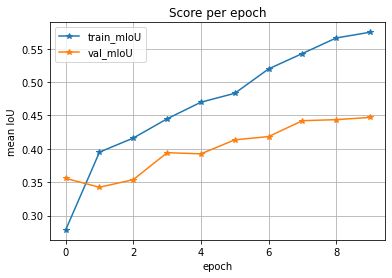

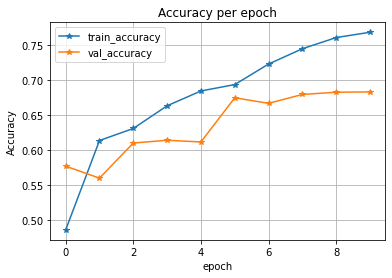

In [22]:
plt.plot(history['val_loss'], label='val', marker='o')
plt.plot( history['train_loss'], label='train', marker='o')
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()
    
plt.plot(history['train_miou'], label='train_mIoU', marker='*')
plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
plt.title('Score per epoch')
plt.ylabel('mean IoU')
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()

plt.plot(history['train_acc'], label='train_accuracy', marker='*')
plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
plt.title('Accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()

### Test:

Cargar el modelo:

In [3]:
model = torch.load('./drive/MyDrive/models/segmentation-unet-2.pt')

In [5]:
data = test_set[5]
pred_mask = predict_image_mask(model, data['image'])

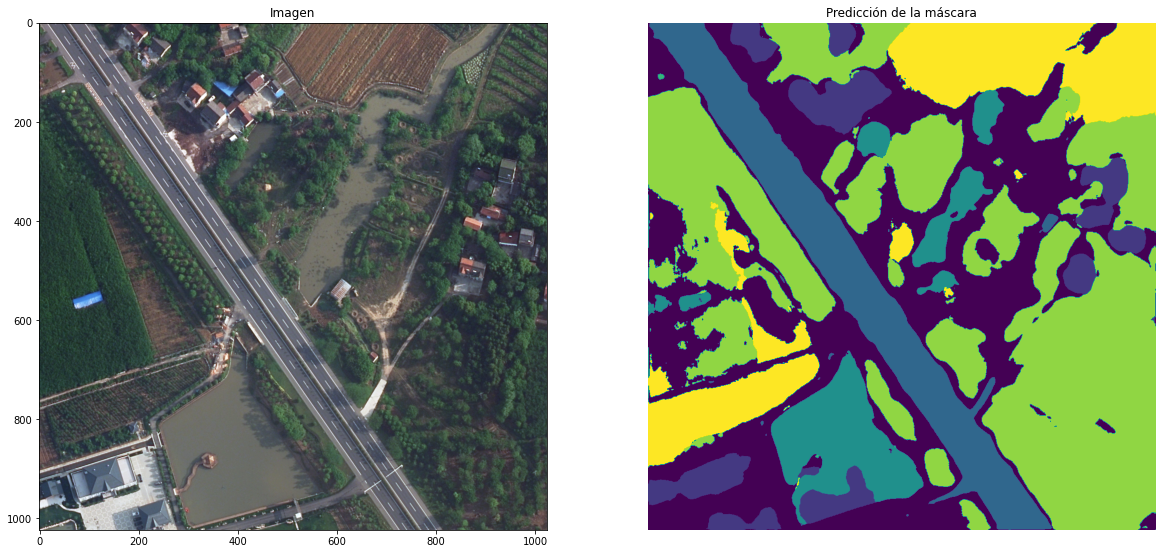

In [34]:
t = T.Compose([T.ToPILImage()])
data['image'] = t(data['image'])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(data['image'])
ax1.set_title('Imagen')

ax2.imshow(pred_mask)
ax2.set_title('Predicción de la máscara')
ax2.set_axis_off()

### Cargar imágen del proyecto:

In [28]:
# Se lee la imagen según su indice
image = cv2.imread('./drive/MyDrive/data/02/ORTO.tif')
# Convierte los colores de la imagen de BGR a RGB  
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = A.Resize(1024, 1024, interpolation=cv2.INTER_NEAREST)

aug = transform(image=image)
image = Image.fromarray(aug['image'])
t = T.Compose([T.ToTensor()])
image = t(image)

In [29]:
pred_mask = predict_image_mask(model, image)

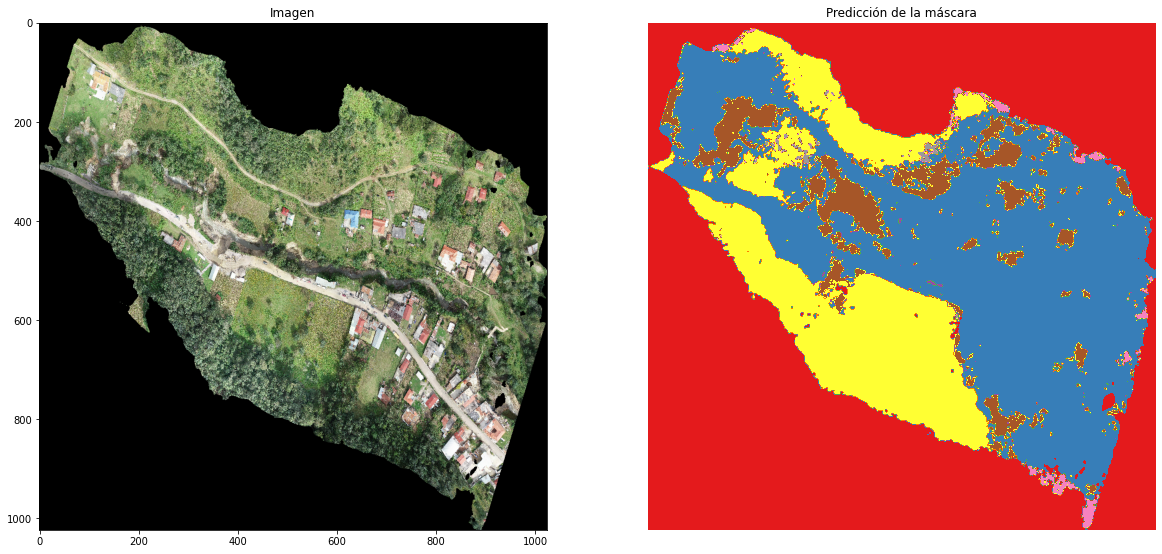

In [68]:
# pred_mask = pred_mask.numpy().astype('uint8')

# t = T.Compose([T.ToPILImage()])
# image = t(image)
# pred_mask = t(pred_mask)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Imagen')

ax2.imshow(pred_mask, cmap='Set1')
ax2.set_title('Predicción de la máscara')
ax2.set_axis_off()

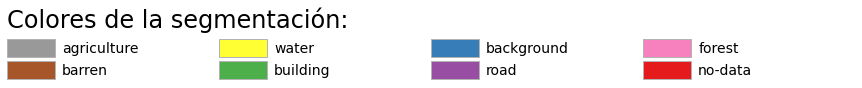

In [67]:
classes = ["no-data", "background", "building", "road", "water", "barren", "forest", "agriculture"]
viridis = cm.get_cmap('Set1', 8)
colors = dict()
for i in range(8):
    r, g, b, *_ = viridis(i)
    colors[classes[i]] = (r, g, b)
plot_colortable(colors, "Colores de la segmentación:")
plt.show()